In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
import sys
sys.path.append('../../') #takes us to the directory named foreground_functions that housed the foreground_function.py 
#and the w3j.npy files

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize
import emcee
import corner

Populating the interactive namespace from numpy and matplotlib


# Foreground parameters

In [3]:
#the parameters chosen here (except gamma) are from the BICEP 2018 paper. The alphas differ by addition of 2, as we've
#calculated the C_ells, while the BICEP paper models the D_ells. The amplitudes also have had to be scaled to pivot
#frequency of 95 GHz so differ by a factor (95/original pivot)^beta
A_s_BICEP = 1.0 #micro K^2
A_d_BICEP = 4.6 #micro K^2
alpha_s_BICEP = -0.6
alpha_d_BICEP = -0.4


alpha_s = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_s = -3.1
gamma_s = 0 #-2.5
A_s = A_s_BICEP * (ff.scale_synch(95e9, beta_s)/ff.scale_synch(23e9, beta_s))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_s = A_s[0]
params_s = [A_s, alpha_s, beta_s, gamma_s]
alpha_d = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_d = 1.6
gamma_d = 0 #-3.5
A_d = A_d_BICEP * (ff.scale_synch(95e9, beta_d)/ff.scale_synch(353e9, beta_d))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_d = A_d[0]
params_d = [A_d, alpha_d, beta_d, gamma_d] 

params = params_s + params_d

nside=128
ells = np.arange(384)
freqs = np.array([30, 40, 60, 95, 120, 150, 210, 230, 260, 290])*1.e9 

In [4]:
print(A_s, A_d)

2.2573626192909638e-07 6.333974970372965e-07


# CMB data

In [39]:
#the D_ells of the CMB with r=0.01
camb_lens_r1 = loadtxt('../../power_spectra/camb_lens_r1.dat').T
camb_lens_nobb = loadtxt('../../power_spectra/camb_lens_nobb.dat').T
primo_bb = camb_lens_r1[3]
lens_bb = camb_lens_nobb[3]
r = 0.01
bb_001 = (r * primo_bb + lens_bb)[:384]

In [38]:
def cmb(ells, r):
    return r*primo_bb[:len(ells)] + lens_bb[:len(ells)]

In [15]:
def cosmic_var(model):
    var = np.zeros((len(freqs),len(ells)))
    cosmic_var = 2/(2*ells + 1) * model**2
    return cosmic_var

In [42]:
input_model = ff.auto0x0_fg(ells, freqs, params) + cmb(ells, 0.01)
input_cosmic_var = cosmic_var(input_model)

In [34]:
def chi2_cmb(params, ells, freqs, data):
    A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, r = params
    long_params = [A_s, alpha_s, beta_s, 0.0, A_d, alpha_d, beta_d, 0.0]

    chi2=0
    model_made = ff.auto0x0_fg(ells, freqs, long_params) + cmb(ells, r)
#     cosmic_var = input_cosmic_var
#     cosmic_var = cosmic_var(model_made)


    #don't count the first 30 ell in the objective function.
    chi2 = (data[:,30:] - model_made[:,30:])**2 / input_cosmic_var[:,30:]
    return np.sum(chi2)

In [35]:
data_synch = ff.const_ps_data_synch(ells, freqs, params_s)
data_dust = ff.const_ps_data_dust(ells, freqs, params_d)
data_fg = ff.const_ps_data_fg(ells, freqs, params)

In [40]:
signal = data_fg + bb_001

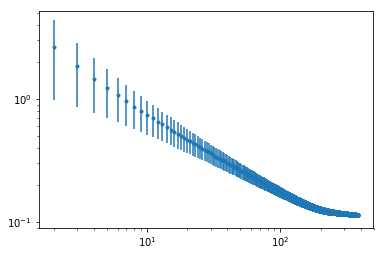

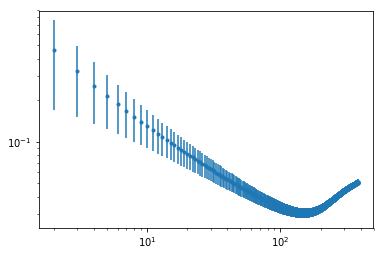

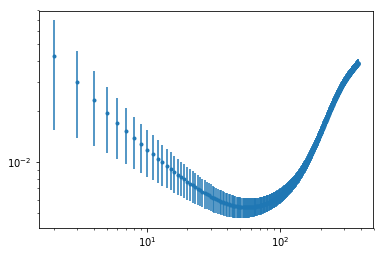

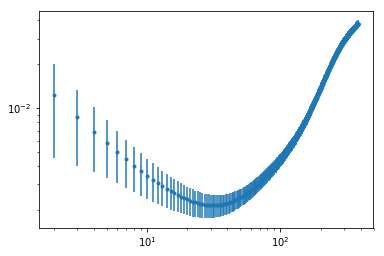

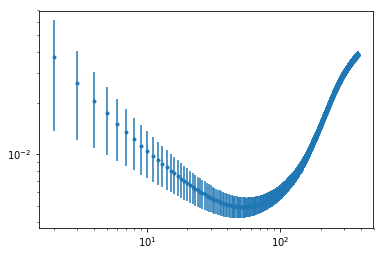

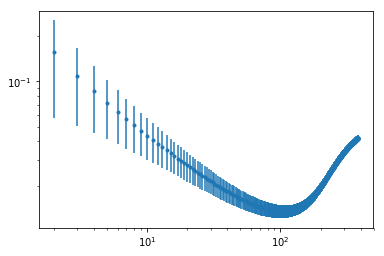

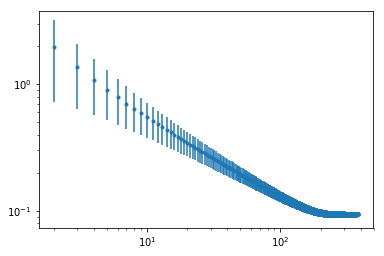

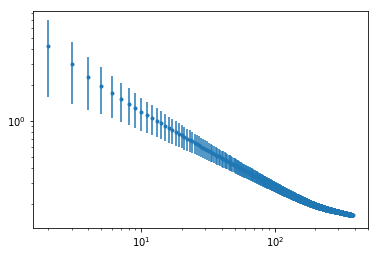

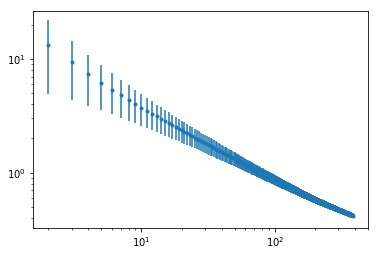

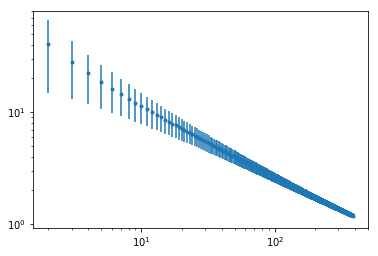

In [43]:
for i in range(len(freqs)):
    figure()
    errorbar(ells[2:], input_model[i][2:], np.sqrt(input_cosmic_var[i][2:]), fmt='.')
    yscale('log')
    xscale('log')

In [44]:
# initial_cmb = [A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, r]
initial_cmb = [1.e-7, -3., -2.5, 1.e-7, -3., 2., 1.e-1]

In [45]:
start=time.time()
result = minimize(chi2_cmb, initial_cmb, args=(ells, freqs, signal), method='Powell')
print(time.time()-start)
print(result)

0.37053799629211426
   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.50862731e-08,  1.00091321e-03, -2.79331117e-02,
         1.74498437e-08,  1.03915888e-02, -1.86807430e-02,
         1.71563877e-04],
       [-5.25110606e-08, -7.18186291e-02, -1.16775074e-01,
         8.51046745e-08, -6.99919406e-02, -3.93575678e-02,
        -1.67801134e-03],
       [-9.65106273e-08, -5.40005987e-02, -1.16509376e-01,
         2.57768250e-08,  1.49449433e-02, -5.22216838e-02,
         2.40994127e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-3.67501158e-09,  9.03739110e-03, -3.54923121e-03,
         2.16835041e-09, -4.78598511e-03,  1.04

In [46]:
x = result.x
long_x = np.zeros(8)
long_x[:3] = x[:3]
long_x[4:] = x[3:len(x)]
long_x[-1] = 0 #set the gammas to 0 as it doesn't matter what they are.
print(long_x)
fit = ff.auto0x0_fg(ells, freqs, long_x) + cmb(ells, x[-1])
input_model = ff.auto0x0_fg(ells, freqs, params) + cmb(ells, 0.01)

[ 2.37800798e-07 -2.59747237e+00 -3.07284661e+00  0.00000000e+00
  6.59832665e-07 -2.60865486e+00  1.58387354e+00  0.00000000e+00]


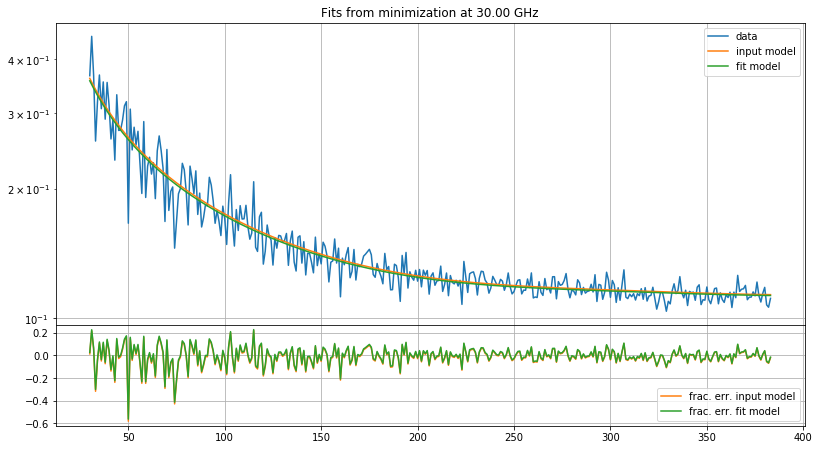

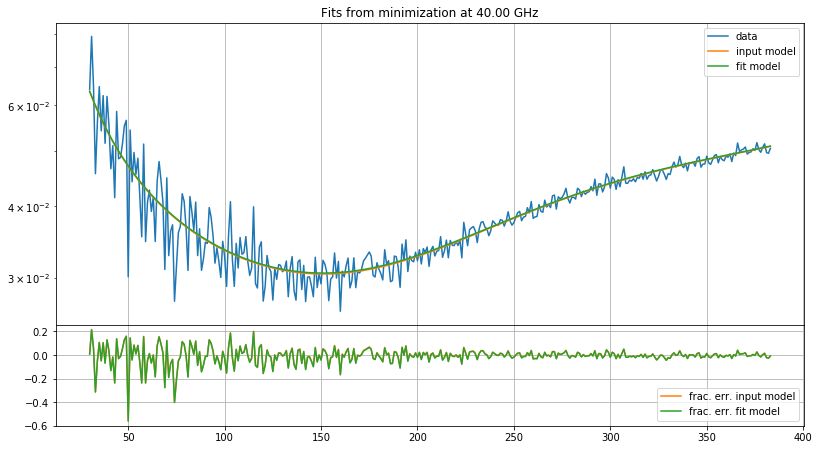

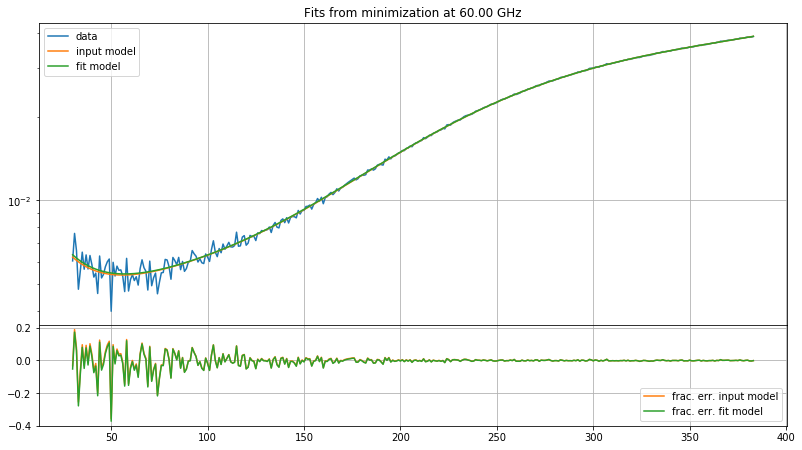

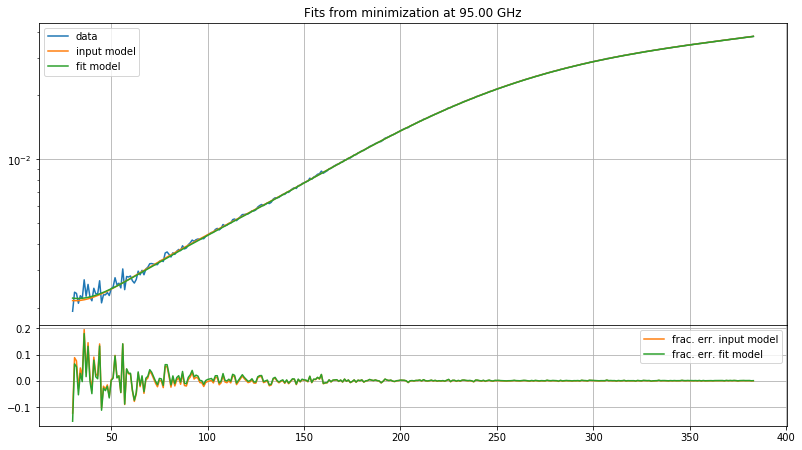

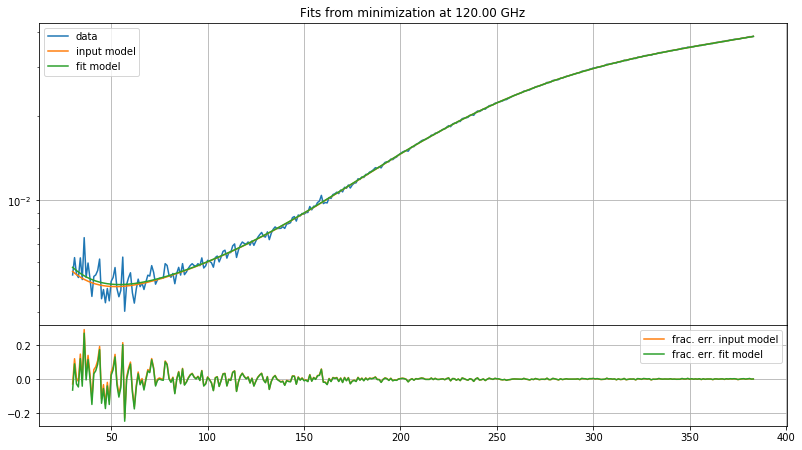

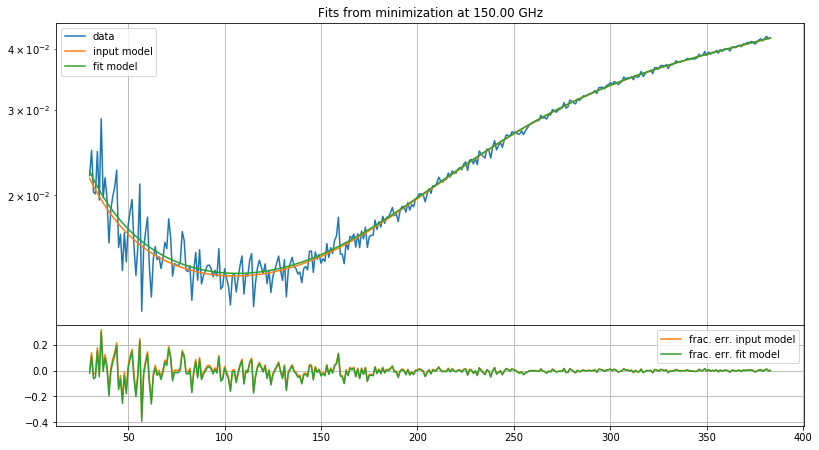

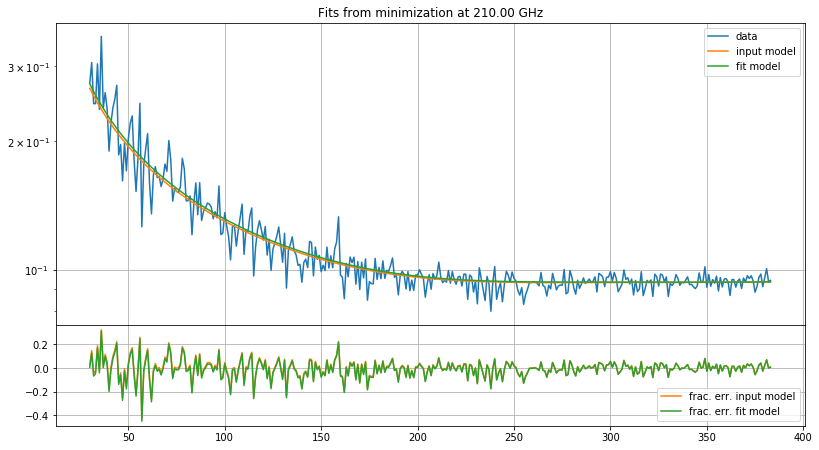

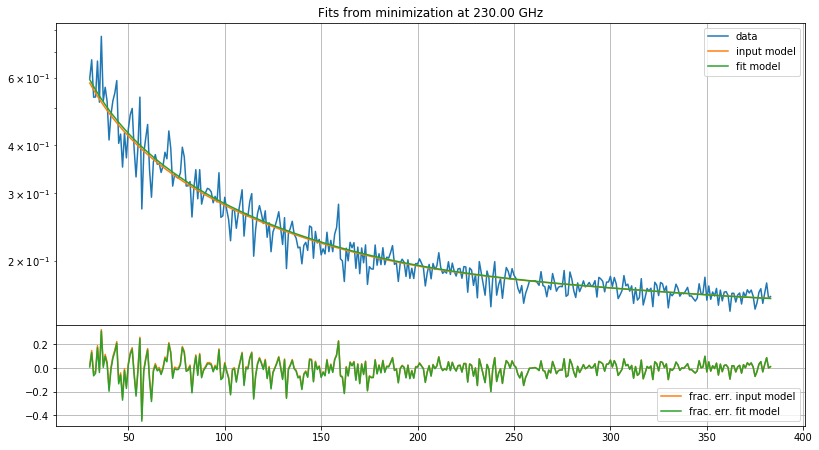

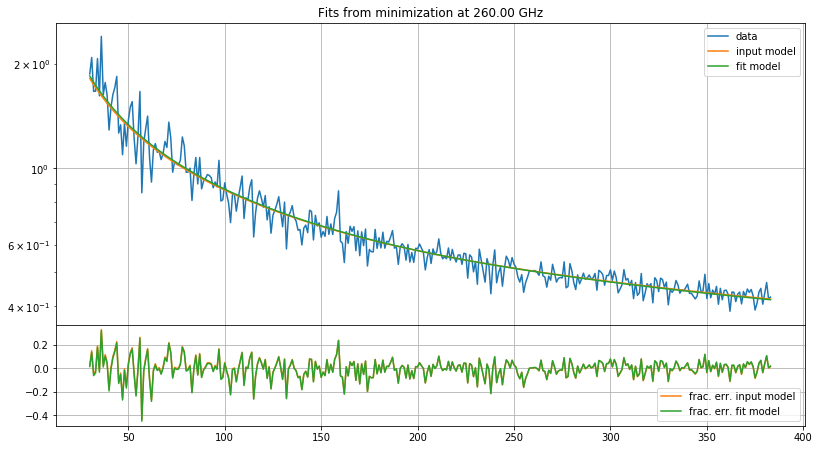

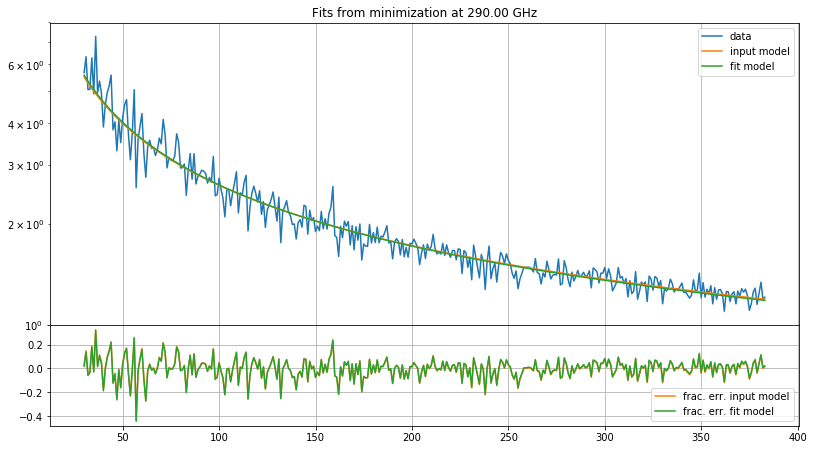

In [47]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], signal[i][30:], label='data')
    semilogy(ells[30:], input_model[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit[i][30:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (signal[i][30:]-input_model[i][30:])/signal[i][30:], color='C1', label='frac. err. input model')
    plot(ells[30:], (signal[i][30:]-fit[i][30:])/signal[i][30:], color='C2', label='frac. err. fit model')
    legend()
    grid()

In [44]:
amp_dls_s = hp.anafast(ampmap_s)
amp_dls_d = hp.anafast(ampmap_d)

In [46]:
new_dls_s = hp.anafast(newmap_s[n])
new_dls_d = hp.anafast(newmap_d[n])

In [47]:
amp_dls_d-new_dls_d

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [48]:
amp_dls_s-new_dls_s

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [50]:
#okay, so the SED is really 1 at 95 GHz for both synch and dust, that's good.

In [43]:
SED_s = ff.scale_synch(freqs, beta_s)
SED_d = ff.scale_dust(freqs, beta_d)

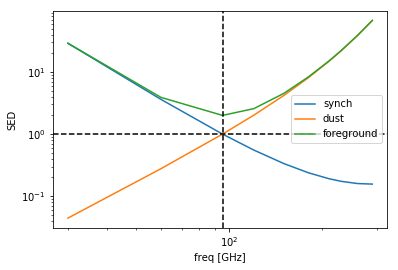

In [48]:
loglog(freqs*1e-9, SED_s, label='synch')
loglog(freqs*1e-9, SED_d, label='dust')
loglog(freqs*1e-9, SED_s+SED_d, label='foreground')
xlabel('freq [GHz]')
ylabel('SED')
axvline(95, color='k', ls='--')
axhline(y=1, color='k', ls='--')
legend()

# check what's going on with the SED that are not normalised to the Planck function

In [45]:
freqs1 = np.linspace(30,3000)*1.e9

In [46]:
SED_normal_s = ff.normed_synch(freqs1, beta_s)
SED_normal_d = ff.normed_dust(freqs1, beta_d)

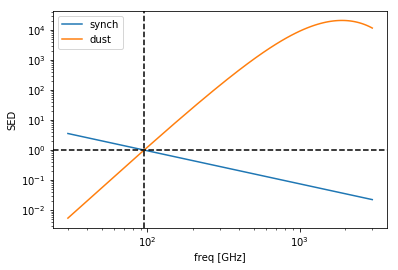

In [47]:
loglog(freqs1*1e-9, SED_normal_s, label='synch')
loglog(freqs1*1e-9, SED_normal_d, label='dust')
xlabel('freq [GHz]')
ylabel('SED')
axvline(95, color='k', ls='--')
axhline(y=1, color='k', ls='--')
legend()

# okay, so these seem to be behaving correctly

In [36]:
%autoreload

In [39]:
ff.chi2_fg(params, ells, freqs, signal)

69574913275546.97

In [40]:
%timeit ff.chi2_dust(params_d, ells, freqs, signal)

43.4 ms ± 4.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
%autoreload

In [65]:
reader = emcee.backends.HDFBackend('./chains/chain.h5')


AttributeError: You must run the sampler with 'store == True' before accessing the results

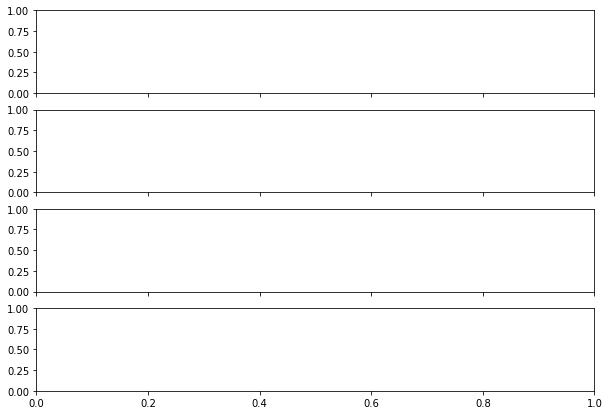

In [66]:
#case of loaded in MCMC
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_read = reader.get_chain()
labels = ["A", r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_read[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_read))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [45]:
samples_read.shape

(32, 10, 4)

In [53]:
fig = corner.corner(samples_read, labels=labels);

AssertionError: The input sample array must be 1- or 2-D.

In [92]:
reader = emcee.backends.HDFBackend('../../mcmc/scripts/tutorial.h5')

tau = reader.get_autocorr_time()
burnin = int(2*np.max(tau))
thin = int(0.5*np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))


/anaconda3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/anaconda3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/anaconda3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [31.02644898 36.00923291         nan 55.0182771 ]

IndexError: index 4 is out of bounds for axis 0 with size 4

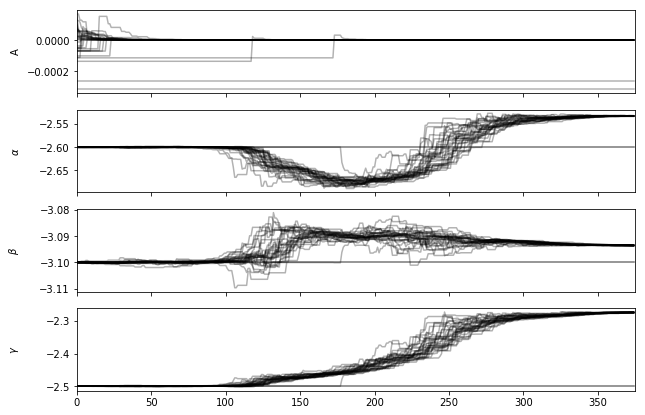

In [93]:
#case of loaded in MCMC
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_read = reader.get_chain()
labels = ["A", r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_read[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_read))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [78]:
#need to generate a new reference power spectrum to try to fit

In [79]:
ref_path = '../../power_spectra/reference_ps.npy'

In [80]:
#ref params (synch only)
ref_params = params_s

In [81]:
ref_params

[2.2573626192909638e-07, -2.6, -3.1, -2.5]

In [82]:
ref = ff.ps_data_synch(ells, freqs, ref_params)

In [91]:
np.save(ref_path, ref)

In [89]:
ref_map = ff.map_synch(ells, freqs, ref_params)

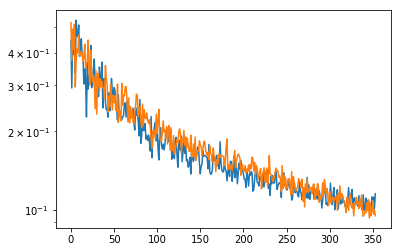

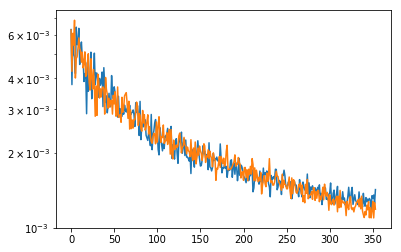

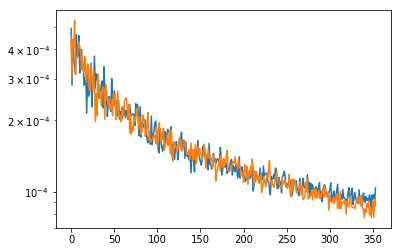

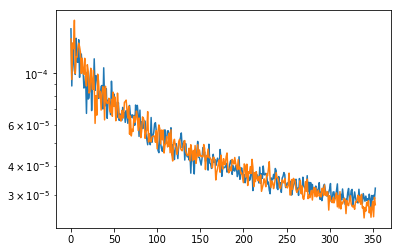

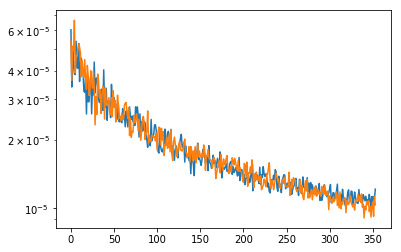

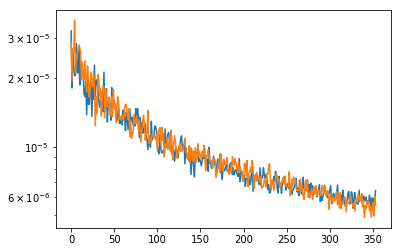

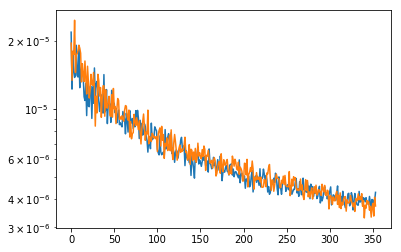

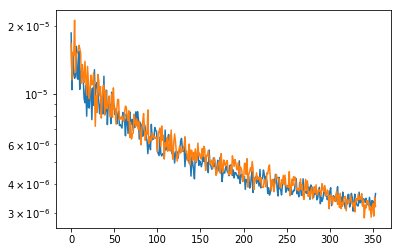

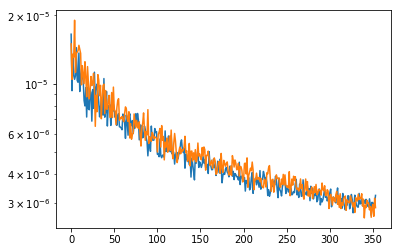

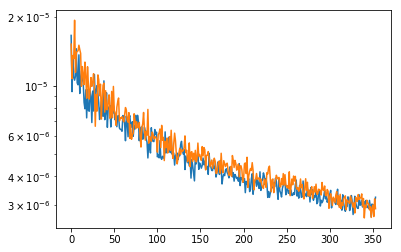

In [90]:
for i in range(len(freqs)):
    figure()
    semilogy(ref[i][30:])
    semilogy((ells*(ells+1)*hp.anafast(ref_map[i])/(2*pi))[30:])